In [ ]:

#colab file link:-
#https://colab.research.google.com/drive/1-XTZQquVsXSCeTXLpgTVBjgOdsOlkesX?usp=sharing


In [ ]:
from __future__ import division
import numpy as np
import torch
import os
import logging
from torch.utils.data import DataLoader, Dataset, Sampler
import argparse


dataloader

In [ ]:
from __future__ import absolute_import
from __future__ import print_function
from datetime import datetime, timedelta
import pandas as pd
import math
import random
from tqdm import trange

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

from math import sqrt
from pandas import read_csv, DataFrame
from scipy import stats

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [ ]:
import json
import shutil
from tqdm import tqdm
import sys
import model.net as net

In [ ]:

import multiprocessing
from copy import copy
from itertools import product
from subprocess import check_call

import numpy as np
import utils


dataset + preprocessing

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, data_path, data_name, num_class):
        self.data = np.load(os.path.join(data_path, f'train_data_{data_name}.npy'))
        self.label = np.load(os.path.join(data_path, f'train_label_{data_name}.npy'))
        self.train_len = self.data.shape[0]
        logger.info(f'train_len: {self.train_len}')
        logger.info(f'building datasets from {data_path}...')

    def __len__(self):
        return self.train_len

    def __getitem__(self, index):
        return (self.data[index,:,:-1],int(self.data[index,0,-1]), self.label[index])


class TestDataset(Dataset):
    def __init__(self, data_path, data_name, num_class):
        self.data = np.load(os.path.join(data_path, f'test_data_{data_name}.npy'))
        self.v = np.load(os.path.join(data_path, f'test_v_{data_name}.npy'))
        self.label = np.load(os.path.join(data_path, f'test_label_{data_name}.npy'))
        self.test_len = self.data.shape[0]
        logger.info(f'test_len: {self.test_len}')
        logger.info(f'building datasets from {data_path}...')

    def __len__(self):
        return self.test_len

    def __getitem__(self, index):
        return (self.data[index,:,:-1],int(self.data[index,0,-1]),self.v[index],self.label[index])


class WeightedSampler(Sampler):
    def __init__(self, data_path, data_name, replacement=True):
        v = np.load(os.path.join(data_path, f'train_v_{data_name}.npy'))
        self.weights = torch.as_tensor(np.abs(v[:,0])/np.sum(np.abs(v[:,0])), dtype=torch.double)
        logger.info(f'weights: {self.weights}')
        self.num_samples = self.weights.shape[0]
        logger.info(f'num samples: {self.num_samples}')
        self.replacement = replacement

    def __iter__(self):
        return iter(torch.multinomial(self.weights, self.num_samples, self.replacement).tolist())

    def __len__(self):
        return self.num_samples

In [ ]:
def prep_data(data, covariates, data_start, train = True):
    time_len = data.shape[0]
    input_size = window_size-stride_size
    windows_per_series = np.full((num_series), (time_len-input_size) // stride_size)
    if train: windows_per_series -= (data_start+stride_size-1) // stride_size
    total_windows = np.sum(windows_per_series)
    x_input = np.zeros((total_windows, window_size, 1 + num_covariates + 1), dtype='float32')
    label = np.zeros((total_windows, window_size), dtype='float32')
    v_input = np.zeros((total_windows, 2), dtype='float32')
    count = 0
    if not train:
        covariates = covariates[-time_len:]
    for series in trange(num_series):
        cov_age = stats.zscore(np.arange(total_time-data_start[series]))
        if train:
            covariates[data_start[series]:time_len, 0] = cov_age[:time_len-data_start[series]]
        else:
            covariates[:, 0] = cov_age[-time_len:]
        for i in range(windows_per_series[series]):
            if train:
                window_start = stride_size*i+data_start[series]
            else:
                window_start = stride_size*i
            window_end = window_start+window_size
            x_input[count, 1:, 0] = data[window_start:window_end-1, series]
            x_input[count, :, 1:1+num_covariates] = covariates[window_start:window_end, :]
            x_input[count, :, -1] = series
            label[count, :] = data[window_start:window_end, series]
            nonzero_sum = (x_input[count, 1:input_size, 0]!=0).sum()
            if nonzero_sum == 0:
                v_input[count, 0] = 0
            else:
                v_input[count, 0] = np.true_divide(x_input[count, 1:input_size, 0].sum(),nonzero_sum)+1
                x_input[count, :, 0] = x_input[count, :, 0]/v_input[count, 0]
                if train:
                    label[count, :] = label[count, :]/v_input[count, 0]
            count += 1
    prefix = os.path.join(save_path, 'train_' if train else 'test_')
    np.save(prefix+'data_'+save_name, x_input)
    np.save(prefix+'v_'+save_name, v_input)
    np.save(prefix+'label_'+save_name, label)

def gen_covariates(times, num_covariates):
    covariates = np.zeros((times.shape[0], num_covariates))
    for i, input_time in enumerate(times):
        covariates[i, 1] = input_time.weekday()
        covariates[i, 2] = input_time.hour
        covariates[i, 3] = input_time.month
    for i in range(1,num_covariates):
        covariates[:,i] = stats.zscore(covariates[:,i])
    return covariates[:, :num_covariates]

def visualize(data, week_start):
    x = np.arange(window_size)
    f = plt.figure()
    plt.plot(x, data[week_start:week_start+window_size], color='b')
    f.savefig("visual.png")
    plt.close()

if __name__ == '__main__':

    global save_path
    name = 'LD2011_2014.txt'
    save_name = 'elect'
    window_size = 192
    stride_size = 24
    num_covariates = 4
    train_start = '2011-01-01 00:00:00'
    train_end = '2014-08-31 23:00:00'
    test_start = '2014-08-25 00:00:00' #need additional 7 days as given info
    test_end = '2014-09-07 23:00:00'
    pred_days = 7
    given_days = 7

    save_path = os.path.join('data', save_name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    csv_path = os.path.join(save_path, name)
    if not os.path.exists(csv_path):
        zipurl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip'
        with urlopen(zipurl) as zipresp:
            with ZipFile(BytesIO(zipresp.read())) as zfile:
                zfile.extractall(save_path)

    data_frame = pd.read_csv(csv_path, sep=";", index_col=0, parse_dates=True, decimal=',')
    data_frame = data_frame.resample('1H',label = 'left',closed = 'right').sum()[train_start:test_end]
    data_frame.fillna(0, inplace=True)
    covariates = gen_covariates(data_frame[train_start:test_end].index, num_covariates)
    train_data = data_frame[train_start:train_end].values
    test_data = data_frame[test_start:test_end].values
    data_start = (train_data!=0).argmax(axis=0) #find first nonzero value in each time series
    total_time = data_frame.shape[0] #32304
    num_series = data_frame.shape[1] #370
    prep_data(train_data, covariates, data_start)
    prep_data(test_data, covariates, data_start, train=False)

100%|██████████| 370/370 [00:00<00:00, 1454.90it/s]


utils

In [ ]:

class Params:
    '''Class that loads hyperparameters from a json file.
    Example:
    params = Params(json_path)
    print(params.learning_rate)
    '''

    def __init__(self, json_path):
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    def save(self, json_path):
        with open(json_path, 'w') as f:
            json.dump(self.__dict__, f, indent=4, ensure_ascii=False)

    def update(self, json_path):
        '''Loads parameters from json file'''
        with open(json_path) as f:
            params = json.load(f)
            self.__dict__.update(params)

    @property
    def dict(self):
        return self.__dict__


class RunningAverage:

    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)


def set_logger(log_path):
    _logger = logging.getLogger('DeepAR')
    _logger.setLevel(logging.INFO)

    fmt = logging.Formatter('[%(asctime)s] %(name)s: %(message)s', '%H:%M:%S')

    class TqdmHandler(logging.StreamHandler):
        def __init__(self, formatter):
            logging.StreamHandler.__init__(self)
            self.setFormatter(formatter)

        def emit(self, record):
            msg = self.format(record)
            tqdm.write(msg)

    file_handler = logging.FileHandler(log_path)
    file_handler.setFormatter(fmt)
    _logger.addHandler(file_handler)
    _logger.addHandler(TqdmHandler(fmt))


def save_dict_to_json(d, json_path):
    with open(json_path, 'w') as f:
        # We need to convert the values to float for json (it doesn't accept np.array, np.float, )
        d = {k: float(v) for k, v in d.items()}
        json.dump(d, f, indent=4)


def save_checkpoint(state, is_best, epoch, checkpoint, ins_name=-1):
    '''Saves model and training parameters at checkpoint + 'last.pth.tar'. If is_best==True, also saves
    checkpoint + 'best.pth.tar' '''
    if ins_name == -1:
        filepath = os.path.join(checkpoint, f'epoch_{epoch}.pth.tar')
    else:
        filepath = os.path.join(checkpoint, f'epoch_{epoch}_ins_{ins_name}.pth.tar')
    if not os.path.exists(checkpoint):
        logger.info(f'Checkpoint Directory does not exist! Making directory {checkpoint}')
        os.mkdir(checkpoint)
    torch.save(state, filepath)
    logger.info(f'Checkpoint saved to {filepath}')
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'best.pth.tar'))
        logger.info('Best checkpoint copied to best.pth.tar')


def load_checkpoint(checkpoint, model, optimizer=None):
    '''Loads model parameters (state_dict) from file_path. If optimizer is provided, loads state_dict of
    optimizer assuming it is present in checkpoint.'''
    if not os.path.exists(checkpoint):
        raise FileNotFoundError(f"File doesn't exist {checkpoint}")
    if torch.cuda.is_available():
        checkpoint = torch.load(checkpoint, map_location='cuda')
    else:
        checkpoint = torch.load(checkpoint, map_location='cpu')
    model.load_state_dict(checkpoint['state_dict'])

    if optimizer:
        optimizer.load_state_dict(checkpoint['optim_dict'])

    return checkpoint


def plot_all_epoch(variable, save_name, location='./figures/'):
    num_samples = variable.shape[0]
    x = np.arange(start=1, stop=num_samples + 1)
    f = plt.figure()
    plt.plot(x, variable[:num_samples])
    f.savefig(os.path.join(location, save_name + '_summary.png'))
    plt.close()


def init_metrics(sample=True):
    metrics = {
        'ND': np.zeros(2),
        'RMSE': np.zeros(3),
        'test_loss': np.zeros(2),
    }
    if sample:
        metrics['rou90'] = np.zeros(2)
        metrics['rou50'] = np.zeros(2)
    return metrics

def get_metrics(sample_mu, labels, predict_start, samples=None, relative=False):
    metric = dict()
    metric['ND'] = net.accuracy_ND_(sample_mu, labels[:, predict_start:], relative=relative)
    metric['RMSE'] = net.accuracy_RMSE_(sample_mu, labels[:, predict_start:], relative=relative)
    if samples is not None:
        metric['rou90'] = net.accuracy_ROU_(0.9, samples, labels[:, predict_start:], relative=relative)
        metric['rou50'] = net.accuracy_ROU_(0.5, samples, labels[:, predict_start:], relative=relative)
    return metric

def update_metrics(raw_metrics, input_mu, input_sigma, sample_mu, labels, predict_start, samples=None, relative=False):
    raw_metrics['ND'] = raw_metrics['ND'] + net.accuracy_ND(sample_mu, labels[:, predict_start:], relative=relative)
    raw_metrics['RMSE'] = raw_metrics['RMSE'] + net.accuracy_RMSE(sample_mu, labels[:, predict_start:], relative=relative)
    input_time_steps = input_mu.numel()
    raw_metrics['test_loss'] = raw_metrics['test_loss'] + [
        net.loss_fn(input_mu, input_sigma, labels[:, :predict_start]) * input_time_steps, input_time_steps]
    if samples is not None:
        raw_metrics['rou90'] = raw_metrics['rou90'] + net.accuracy_ROU(0.9, samples, labels[:, predict_start:], relative=relative)
        raw_metrics['rou50'] = raw_metrics['rou50'] + net.accuracy_ROU(0.5, samples, labels[:, predict_start:], relative=relative)
    return raw_metrics


def final_metrics(raw_metrics, sampling=False):
    summary_metric = {}
    summary_metric['ND'] = raw_metrics['ND'][0] / raw_metrics['ND'][1]
    summary_metric['RMSE'] = np.sqrt(raw_metrics['RMSE'][0] / raw_metrics['RMSE'][2]) / (
                raw_metrics['RMSE'][1] / raw_metrics['RMSE'][2])
    summary_metric['test_loss'] = (raw_metrics['test_loss'][0] / raw_metrics['test_loss'][1]).item()
    if sampling:
        summary_metric['rou90'] = raw_metrics['rou90'][0] / raw_metrics['rou90'][1]
        summary_metric['rou50'] = raw_metrics['rou50'][0] / raw_metrics['rou50'][1]
    return summary_metric

In [ ]:
import argparse
import logging
import os

import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data.sampler import RandomSampler
from tqdm import tqdm

import utils
import model.net as net
from evaluate import evaluate
from dataloader import *

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt



LSTM

In [ ]:

import torch
import torch.nn as nn
from torch.nn.utils.rnn import PackedSequence
from typing import *


class VariationalDropout(nn.Module):

    def __init__(self, dropout: float, batch_first: Optional[bool]=False):
        super().__init__()
        self.dropout = dropout
        self.batch_first = batch_first

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if not self.training or self.dropout <= 0.:
            return x

        is_packed = isinstance(x, PackedSequence)
        if is_packed:
            x, batch_sizes = x
            max_batch_size = int(batch_sizes[0])
        else:
            batch_sizes = None
            max_batch_size = x.size(0)

        if self.batch_first:
            m = x.new_empty(max_batch_size, 1, x.size(2), requires_grad=False).bernoulli_(1 - self.dropout)
        else:
            m = x.new_empty(1, max_batch_size, x.size(2), requires_grad=False).bernoulli_(1 - self.dropout)
        x = x.masked_fill(m == 0, 0) / (1 - self.dropout)

        if is_packed:
            return PackedSequence(x, batch_sizes)
        else:
            return x

class LSTM(nn.LSTM):
    def __init__(self, *args, dropouti: float=0.,
                 dropoutw: float=0., dropouto: float=0.,
                 batch_first=True, unit_forget_bias=True, **kwargs):
        super().__init__(*args, **kwargs, batch_first=batch_first)
        self.unit_forget_bias = unit_forget_bias
        self.dropoutw = dropoutw
        self.input_drop = VariationalDropout(dropouti,
                                             batch_first=batch_first)
        self.output_drop = VariationalDropout(dropouto,
                                              batch_first=batch_first)
        self._init_weights()

    def _init_weights(self):

        for name, param in self.named_parameters():
            if "weight_hh" in name:
                nn.init.orthogonal_(param.data)
            elif "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
            elif "bias" in name and self.unit_forget_bias:
                nn.init.zeros_(param.data)
                param.data[self.hidden_size:2 * self.hidden_size] = 1

    def _drop_weights(self):
        for name, param in self.named_parameters():
            if "weight_hh" in name:
                getattr(self, name).data = \
                    torch.nn.functional.dropout(param.data, p=self.dropoutw,
                                                training=self.training).contiguous()

    def forward(self, input, hx=None):
        self._drop_weights()
        input = self.input_drop(input)
        seq, state = super().forward(input, hx=hx)
        return self.output_drop(seq), state

Training the model, used evalution.py as uploaded; model: LSTM.py and net.py as uploaded; base_model:params_json; param_search:params_json

In [ ]:
logger = logging.getLogger('DeepAR.Train')

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='elect', help='Name of the dataset')
parser.add_argument('--data-folder', default='data', help='Parent dir of the dataset')
parser.add_argument('--model-name', default='base_model', help='Directory containing params.json')
parser.add_argument('--relative-metrics', action='store_true', help='Whether to normalize the metrics by label scales')
parser.add_argument('--sampling', action='store_true', help='Whether to sample during evaluation')
parser.add_argument('--save-best', action='store_true', help='Whether to save best ND to param_search.txt')
parser.add_argument('--restore-file', default=None,
                    help='Optional, name of the file in --model_dir containing weights to reload before \
                    training')  # 'best' or 'epoch_#'

class Args:
    def __init__(self):
        self.dataset = 'elect'
        self.data_folder = 'data'
        self.model_name = 'base_model'
        self.relative_metrics = False
        self.sampling = False
        self.save_best = False
        self.restore_file = None

args = Args()

def train(model: nn.Module,
          optimizer: optim,
          loss_fn,
          train_loader: DataLoader,
          test_loader: DataLoader,
          params: utils.Params,
          epoch: int) -> float:
    '''Train the model on one epoch by batches.
    '''
    model.train()
    loss_epoch = np.zeros(len(train_loader))
    # Train_loader:
    # train_batch ([batch_size, train_window, 1+cov_dim]): z_{0:T-1} + x_{1:T}, note that z_0 = 0;
    # idx ([batch_size]): one integer denoting the time series id;
    # labels_batch ([batch_size, train_window]): z_{1:T}.
    for i, (train_batch, idx, labels_batch) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        batch_size = train_batch.shape[0]

        train_batch = train_batch.permute(1, 0, 2).to(torch.float32).to(params.device)  # not scaled
        labels_batch = labels_batch.permute(1, 0).to(torch.float32).to(params.device)  # not scaled
        idx = idx.unsqueeze(0).to(params.device)

        loss = torch.zeros(1, device=params.device)
        hidden = model.init_hidden(batch_size)
        cell = model.init_cell(batch_size)

        for t in range(params.train_window):
            # if z_t is missing, replace it by output mu from the last time step
            zero_index = (train_batch[t, :, 0] == 0)
            if t > 0 and torch.sum(zero_index) > 0:
                train_batch[t, zero_index, 0] = mu[zero_index]
            mu, sigma, hidden, cell = model(train_batch[t].unsqueeze_(0).clone(), idx, hidden, cell)
            loss += loss_fn(mu, sigma, labels_batch[t])

        loss.backward()
        optimizer.step()
        loss = loss.item() / params.train_window  # loss per timestep
        loss_epoch[i] = loss
        if i % 1000 == 0:
            test_metrics = evaluate(model, loss_fn, test_loader, params, epoch, sample=args.sampling)
            model.train()
            logger.info(f'train_loss: {loss}')
        if i == 0:
            logger.info(f'train_loss: {loss}')
    return loss_epoch


def train_and_evaluate(model: nn.Module,
                       train_loader: DataLoader,
                       test_loader: DataLoader,
                       optimizer: optim, loss_fn,
                       params: utils.Params,
                       restore_file: str = None) -> None:
    '''Train the model and evaluate every epoch.
    '''
    # reload weights from restore_file if specified
    if restore_file is not None:
        restore_path = os.path.join(params.model_dir, restore_file + '.pth.tar')
        logger.info('Restoring parameters from {}'.format(restore_path))
        utils.load_checkpoint(restore_path, model, optimizer)
    logger.info('begin training and evaluation')
    best_test_ND = float('inf')
    train_len = len(train_loader)
    ND_summary = np.zeros(params.num_epochs)
    loss_summary = np.zeros((train_len * params.num_epochs))
    #train_losses = []
    #test_losses = []
    for epoch in range(params.num_epochs):
        logger.info('Epoch {}/{}'.format(epoch + 1, params.num_epochs))
        loss_summary[epoch * train_len:(epoch + 1) * train_len] = train(model, optimizer, loss_fn, train_loader,
                                                                        test_loader, params, epoch)
        test_metrics = evaluate(model, loss_fn, test_loader, params, epoch, sample=args.sampling)
        ND_summary[epoch] = test_metrics['ND']
        is_best = ND_summary[epoch] <= best_test_ND

        # Save weights
        utils.save_checkpoint({'epoch': epoch + 1,
                               'state_dict': model.state_dict(),
                               'optim_dict': optimizer.state_dict()},
                              epoch=epoch,
                              is_best=is_best,
                              checkpoint=params.model_dir)

        if is_best:
            logger.info('- Found new best ND')
            best_test_ND = ND_summary[epoch]
            best_json_path = os.path.join(params.model_dir, 'metrics_test_best_weights.json')
            utils.save_dict_to_json(test_metrics, best_json_path)

        logger.info('Current Best ND is: %.5f' % best_test_ND)

        utils.plot_all_epoch(ND_summary[:epoch + 1], args.dataset + '_ND', params.plot_dir)
        utils.plot_all_epoch(loss_summary[:(epoch + 1) * train_len], args.dataset + '_loss', params.plot_dir)

        last_json_path = os.path.join(params.model_dir, 'metrics_test_last_weights.json')
        utils.save_dict_to_json(test_metrics, last_json_path)

    if args.save_best:
        f = open('./param_search.txt', 'w')
        f.write('-----------\n')
        list_of_params = args.search_params.split(',')
        print_params = ''
        for param in list_of_params:
            param_value = getattr(params, param)
            print_params += f'{param}: {param_value:.2f}'
        print_params = print_params[:-1]
        f.write(print_params + '\n')
        f.write('Best ND: ' + str(best_test_ND) + '\n')
        logger.info(print_params)
        logger.info(f'Best ND: {best_test_ND}')
        f.close()
        utils.plot_all_epoch(ND_summary, print_params + '_ND', location=params.plot_dir)
        utils.plot_all_epoch(loss_summary, print_params + '_loss', location=params.plot_dir)

def main():

    args = Args()

    # Load the parameters from json file
    model_dir = os.path.join('experiments', args.model_name)
    json_path = os.path.join(model_dir, 'params.json')
    data_dir = os.path.join(args.data_folder, args.dataset)
    assert os.path.isfile(json_path), f'No json configuration file found at {json_path}'
    params = utils.Params(json_path)

    params.relative_metrics = args.relative_metrics
    params.sampling =  args.sampling
    params.model_dir = model_dir
    params.plot_dir = os.path.join(model_dir, 'figures')


    try:
        os.mkdir(params.plot_dir)
    except FileExistsError:
        pass


    cuda_exist = torch.cuda.is_available()

    if cuda_exist:
        params.device = torch.device('cuda')
        # torch.cuda.manual_seed(240)
        logger.info('Using Cuda...')
        model = net.Net(params).cuda()
    else:
        params.device = torch.device('cpu')
        # torch.manual_seed(230)
        logger.info('Not using cuda...')
        model = net.Net(params)

    utils.set_logger(os.path.join(model_dir, 'train.log'))
    logger.info('Loading the datasets...')

    train_set = TrainDataset(data_dir, args.dataset, params.num_class)
    test_set = TestDataset(data_dir, args.dataset, params.num_class)
    sampler = WeightedSampler(data_dir, args.dataset)
    train_loader = DataLoader(train_set, batch_size=params.batch_size, sampler=sampler, num_workers=4)
    test_loader = DataLoader(test_set, batch_size=params.predict_batch, sampler=RandomSampler(test_set), num_workers=4)
    logger.info('Loading complete.')

    logger.info(f'Model: \n{str(model)}')
    optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)

    # fetch loss function
    loss_fn = net.loss_fn

    # Train the model
    logger.info('Starting training for {} epoch(s)'.format(params.num_epochs))
    train_and_evaluate(model,
                       train_loader,
                       test_loader,
                       optimizer,
                       loss_fn,
                       params,
                       args.restore_file)

if __name__=="__main__":
    main()

INFO:DeepAR.Train:Not using cuda...
INFO:DeepAR.Train:Loading the datasets...


[21:28:37] DeepAR.Train: Not using cuda...
[21:28:37] DeepAR.Train: Not using cuda...
[21:28:37] DeepAR.Train: Not using cuda...
[21:28:37] DeepAR.Train: Not using cuda...
[21:28:37] DeepAR.Train: Loading the datasets...
[21:28:37] DeepAR.Train: Loading the datasets...
[21:28:37] DeepAR.Train: Loading the datasets...
[21:28:37] DeepAR.Train: Loading the datasets...
[21:28:37] DeepAR.Train: Loading the datasets...


INFO:DeepAR.Data:train_len: 389101
INFO:DeepAR.Data:building datasets from data/elect...
INFO:DeepAR.Data:test_len: 2590
INFO:DeepAR.Data:building datasets from data/elect...
INFO:DeepAR.Data:weights: tensor([4.5579e-08, 4.7663e-08, 4.8446e-08,  ..., 8.4827e-05, 8.4776e-05,
        8.4272e-05], dtype=torch.float64)
INFO:DeepAR.Data:num samples: 389101
INFO:DeepAR.Train:Loading complete.
INFO:DeepAR.Train:Model: 
Net(
  (embedding): Embedding(370, 20)
  (lstm): LSTM(25, 40, num_layers=3, dropout=0.1)
  (relu): ReLU()
  (distribution_mu): Linear(in_features=120, out_features=1, bias=True)
  (distribution_presigma): Linear(in_features=120, out_features=1, bias=True)
  (distribution_sigma): Softplus(beta=1, threshold=20)
)
INFO:DeepAR.Train:Starting training for 3 epoch(s)
INFO:DeepAR.Train:begin training and evaluation
INFO:DeepAR.Train:Epoch 1/3


[21:28:41] DeepAR.Data: train_len: 389101
[21:28:41] DeepAR.Data: train_len: 389101
[21:28:41] DeepAR.Data: train_len: 389101
[21:28:41] DeepAR.Data: train_len: 389101
[21:28:41] DeepAR.Data: train_len: 389101
[21:28:41] DeepAR.Data: building datasets from data/elect...
[21:28:41] DeepAR.Data: building datasets from data/elect...
[21:28:41] DeepAR.Data: building datasets from data/elect...
[21:28:41] DeepAR.Data: building datasets from data/elect...
[21:28:41] DeepAR.Data: building datasets from data/elect...
[21:28:41] DeepAR.Data: test_len: 2590
[21:28:41] DeepAR.Data: test_len: 2590
[21:28:41] DeepAR.Data: test_len: 2590
[21:28:41] DeepAR.Data: test_len: 2590
[21:28:41] DeepAR.Data: test_len: 2590
[21:28:41] DeepAR.Data: building datasets from data/elect...
[21:28:41] DeepAR.Data: building datasets from data/elect...
[21:28:41] DeepAR.Data: building datasets from data/elect...
[21:28:41] DeepAR.Data: building datasets from data/elect...
[21:28:41] DeepAR.Data: building datasets from

  0%|          | 1/3040 [00:16<13:40:18, 16.20s/it]

[21:28:57] DeepAR.Eval: - Full test metrics: ND: 0.850; RMSE: 6.066; test_loss: 7.987
[21:28:57] DeepAR.Eval: - Full test metrics: ND: 0.850; RMSE: 6.066; test_loss: 7.987
[21:28:57] DeepAR.Eval: - Full test metrics: ND: 0.850; RMSE: 6.066; test_loss: 7.987
[21:28:57] DeepAR.Eval: - Full test metrics: ND: 0.850; RMSE: 6.066; test_loss: 7.987
[21:28:57] DeepAR.Eval: - Full test metrics: ND: 0.850; RMSE: 6.066; test_loss: 7.987
[21:28:57] DeepAR.Train: train_loss: 1.676200230916341
[21:28:57] DeepAR.Train: train_loss: 1.676200230916341
[21:28:57] DeepAR.Train: train_loss: 1.676200230916341
[21:28:57] DeepAR.Train: train_loss: 1.676200230916341
[21:28:57] DeepAR.Train: train_loss: 1.676200230916341
[21:28:57] DeepAR.Train: train_loss: 1.676200230916341
[21:28:57] DeepAR.Train: train_loss: 1.676200230916341
[21:28:57] DeepAR.Train: train_loss: 1.676200230916341
[21:28:57] DeepAR.Train: train_loss: 1.676200230916341
[21:28:57] DeepAR.Train: train_loss: 1.676200230916341


 33%|███▎      | 1001/3040 [23:02<2:48:41,  4.96s/it]

[21:51:43] DeepAR.Eval: - Full test metrics: ND: 0.096; RMSE: 0.716; test_loss: 5.737
[21:51:43] DeepAR.Eval: - Full test metrics: ND: 0.096; RMSE: 0.716; test_loss: 5.737
[21:51:43] DeepAR.Eval: - Full test metrics: ND: 0.096; RMSE: 0.716; test_loss: 5.737
[21:51:43] DeepAR.Eval: - Full test metrics: ND: 0.096; RMSE: 0.716; test_loss: 5.737
[21:51:43] DeepAR.Eval: - Full test metrics: ND: 0.096; RMSE: 0.716; test_loss: 5.737
[21:51:44] DeepAR.Train: train_loss: -1.1577853361765544
[21:51:44] DeepAR.Train: train_loss: -1.1577853361765544
[21:51:44] DeepAR.Train: train_loss: -1.1577853361765544
[21:51:44] DeepAR.Train: train_loss: -1.1577853361765544
[21:51:44] DeepAR.Train: train_loss: -1.1577853361765544


 66%|██████▌   | 2001/3040 [46:11<1:26:09,  4.98s/it]

[22:14:52] DeepAR.Eval: - Full test metrics: ND: 0.095; RMSE: 0.632; test_loss: 5.632
[22:14:52] DeepAR.Eval: - Full test metrics: ND: 0.095; RMSE: 0.632; test_loss: 5.632
[22:14:52] DeepAR.Eval: - Full test metrics: ND: 0.095; RMSE: 0.632; test_loss: 5.632
[22:14:52] DeepAR.Eval: - Full test metrics: ND: 0.095; RMSE: 0.632; test_loss: 5.632
[22:14:52] DeepAR.Eval: - Full test metrics: ND: 0.095; RMSE: 0.632; test_loss: 5.632
[22:14:52] DeepAR.Train: train_loss: -1.2463403542836506
[22:14:52] DeepAR.Train: train_loss: -1.2463403542836506
[22:14:52] DeepAR.Train: train_loss: -1.2463403542836506
[22:14:52] DeepAR.Train: train_loss: -1.2463403542836506
[22:14:52] DeepAR.Train: train_loss: -1.2463403542836506


 99%|█████████▊| 3001/3040 [1:09:41<03:22,  5.20s/it]

[22:38:23] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.520; test_loss: 5.584
[22:38:23] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.520; test_loss: 5.584
[22:38:23] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.520; test_loss: 5.584
[22:38:23] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.520; test_loss: 5.584
[22:38:23] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.520; test_loss: 5.584
[22:38:23] DeepAR.Train: train_loss: -1.3190477689107258
[22:38:23] DeepAR.Train: train_loss: -1.3190477689107258
[22:38:23] DeepAR.Train: train_loss: -1.3190477689107258
[22:38:23] DeepAR.Train: train_loss: -1.3190477689107258
[22:38:23] DeepAR.Train: train_loss: -1.3190477689107258


100%|██████████| 11/11 [00:16<00:00,  1.48s/it]
INFO:DeepAR.Eval:- Full test metrics: ND: 0.084; RMSE: 0.515; test_loss: 5.578
INFO:DeepAR.Utils:Checkpoint saved to experiments/base_model/epoch_0.pth.tar
INFO:DeepAR.Utils:Best checkpoint copied to best.pth.tar
INFO:DeepAR.Train:- Found new best ND
INFO:DeepAR.Train:Current Best ND is: 0.08441


[22:39:34] DeepAR.Eval: - Full test metrics: ND: 0.084; RMSE: 0.515; test_loss: 5.578
[22:39:34] DeepAR.Eval: - Full test metrics: ND: 0.084; RMSE: 0.515; test_loss: 5.578
[22:39:34] DeepAR.Eval: - Full test metrics: ND: 0.084; RMSE: 0.515; test_loss: 5.578
[22:39:34] DeepAR.Eval: - Full test metrics: ND: 0.084; RMSE: 0.515; test_loss: 5.578
[22:39:34] DeepAR.Eval: - Full test metrics: ND: 0.084; RMSE: 0.515; test_loss: 5.578
[22:39:34] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_0.pth.tar
[22:39:34] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_0.pth.tar
[22:39:34] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_0.pth.tar
[22:39:34] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_0.pth.tar
[22:39:34] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_0.pth.tar
[22:39:34] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[22:39:34] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[22:39:34] DeepAR.Util

INFO:DeepAR.Train:Epoch 2/3


[22:39:34] DeepAR.Train: Epoch 2/3
[22:39:34] DeepAR.Train: Epoch 2/3
[22:39:34] DeepAR.Train: Epoch 2/3
[22:39:34] DeepAR.Train: Epoch 2/3
[22:39:34] DeepAR.Train: Epoch 2/3


  0%|          | 1/3040 [00:15<13:16:40, 15.73s/it]

[22:39:50] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.531; test_loss: 5.576
[22:39:50] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.531; test_loss: 5.576
[22:39:50] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.531; test_loss: 5.576
[22:39:50] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.531; test_loss: 5.576
[22:39:50] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.531; test_loss: 5.576
[22:39:50] DeepAR.Train: train_loss: -1.2896033922831218
[22:39:50] DeepAR.Train: train_loss: -1.2896033922831218
[22:39:50] DeepAR.Train: train_loss: -1.2896033922831218
[22:39:50] DeepAR.Train: train_loss: -1.2896033922831218
[22:39:50] DeepAR.Train: train_loss: -1.2896033922831218
[22:39:50] DeepAR.Train: train_loss: -1.2896033922831218
[22:39:50] DeepAR.Train: train_loss: -1.2896033922831218
[22:39:50] DeepAR.Train: train_loss: -1.2896033922831218
[22:39:50] DeepAR.Train: train_loss: -1.2896033922831218
[22:39:50] DeepAR.Train: train_loss: -1.2896033922831218


 33%|███▎      | 1001/3040 [22:42<2:45:54,  4.88s/it]

[23:02:17] DeepAR.Eval: - Full test metrics: ND: 0.081; RMSE: 0.530; test_loss: 5.545
[23:02:17] DeepAR.Eval: - Full test metrics: ND: 0.081; RMSE: 0.530; test_loss: 5.545
[23:02:17] DeepAR.Eval: - Full test metrics: ND: 0.081; RMSE: 0.530; test_loss: 5.545
[23:02:17] DeepAR.Eval: - Full test metrics: ND: 0.081; RMSE: 0.530; test_loss: 5.545
[23:02:17] DeepAR.Eval: - Full test metrics: ND: 0.081; RMSE: 0.530; test_loss: 5.545
[23:02:17] DeepAR.Train: train_loss: -1.3378861745198567
[23:02:17] DeepAR.Train: train_loss: -1.3378861745198567
[23:02:17] DeepAR.Train: train_loss: -1.3378861745198567
[23:02:17] DeepAR.Train: train_loss: -1.3378861745198567
[23:02:17] DeepAR.Train: train_loss: -1.3378861745198567


 66%|██████▌   | 2001/3040 [43:46<1:15:41,  4.37s/it]

[23:23:21] DeepAR.Eval: - Full test metrics: ND: 0.084; RMSE: 0.528; test_loss: 5.518
[23:23:21] DeepAR.Eval: - Full test metrics: ND: 0.084; RMSE: 0.528; test_loss: 5.518
[23:23:21] DeepAR.Eval: - Full test metrics: ND: 0.084; RMSE: 0.528; test_loss: 5.518
[23:23:21] DeepAR.Eval: - Full test metrics: ND: 0.084; RMSE: 0.528; test_loss: 5.518
[23:23:21] DeepAR.Eval: - Full test metrics: ND: 0.084; RMSE: 0.528; test_loss: 5.518
[23:23:21] DeepAR.Train: train_loss: -1.3034048875172932
[23:23:21] DeepAR.Train: train_loss: -1.3034048875172932
[23:23:21] DeepAR.Train: train_loss: -1.3034048875172932
[23:23:21] DeepAR.Train: train_loss: -1.3034048875172932
[23:23:21] DeepAR.Train: train_loss: -1.3034048875172932


 99%|█████████▊| 3001/3040 [1:04:01<03:05,  4.75s/it]

[23:43:36] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.498; test_loss: 5.493
[23:43:36] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.498; test_loss: 5.493
[23:43:36] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.498; test_loss: 5.493
[23:43:36] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.498; test_loss: 5.493
[23:43:36] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.498; test_loss: 5.493
[23:43:36] DeepAR.Train: train_loss: -1.3129589557647705
[23:43:36] DeepAR.Train: train_loss: -1.3129589557647705
[23:43:36] DeepAR.Train: train_loss: -1.3129589557647705
[23:43:36] DeepAR.Train: train_loss: -1.3129589557647705
[23:43:36] DeepAR.Train: train_loss: -1.3129589557647705


100%|██████████| 11/11 [00:11<00:00,  1.05s/it]
INFO:DeepAR.Eval:- Full test metrics: ND: 0.080; RMSE: 0.482; test_loss: 5.499
INFO:DeepAR.Utils:Checkpoint saved to experiments/base_model/epoch_1.pth.tar
INFO:DeepAR.Utils:Best checkpoint copied to best.pth.tar
INFO:DeepAR.Train:- Found new best ND
INFO:DeepAR.Train:Current Best ND is: 0.07964


[23:44:37] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.482; test_loss: 5.499
[23:44:37] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.482; test_loss: 5.499
[23:44:37] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.482; test_loss: 5.499
[23:44:37] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.482; test_loss: 5.499
[23:44:37] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.482; test_loss: 5.499
[23:44:37] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_1.pth.tar
[23:44:37] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_1.pth.tar
[23:44:37] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_1.pth.tar
[23:44:37] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_1.pth.tar
[23:44:37] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_1.pth.tar
[23:44:37] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[23:44:37] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[23:44:37] DeepAR.Util

INFO:DeepAR.Train:Epoch 3/3


[23:44:37] DeepAR.Train: Epoch 3/3
[23:44:37] DeepAR.Train: Epoch 3/3
[23:44:37] DeepAR.Train: Epoch 3/3
[23:44:37] DeepAR.Train: Epoch 3/3
[23:44:37] DeepAR.Train: Epoch 3/3


  0%|          | 1/3040 [00:14<12:21:59, 14.65s/it]

[23:44:52] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.490; test_loss: 5.499
[23:44:52] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.490; test_loss: 5.499
[23:44:52] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.490; test_loss: 5.499
[23:44:52] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.490; test_loss: 5.499
[23:44:52] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.490; test_loss: 5.499
[23:44:52] DeepAR.Train: train_loss: -1.4383325576782227
[23:44:52] DeepAR.Train: train_loss: -1.4383325576782227
[23:44:52] DeepAR.Train: train_loss: -1.4383325576782227
[23:44:52] DeepAR.Train: train_loss: -1.4383325576782227
[23:44:52] DeepAR.Train: train_loss: -1.4383325576782227
[23:44:52] DeepAR.Train: train_loss: -1.4383325576782227
[23:44:52] DeepAR.Train: train_loss: -1.4383325576782227
[23:44:52] DeepAR.Train: train_loss: -1.4383325576782227
[23:44:52] DeepAR.Train: train_loss: -1.4383325576782227
[23:44:52] DeepAR.Train: train_loss: -1.4383325576782227


 33%|███▎      | 1001/3040 [20:36<2:39:11,  4.68s/it]

[00:05:14] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.511; test_loss: 5.485
[00:05:14] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.511; test_loss: 5.485
[00:05:14] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.511; test_loss: 5.485
[00:05:14] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.511; test_loss: 5.485
[00:05:14] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.511; test_loss: 5.485
[00:05:14] DeepAR.Train: train_loss: -1.4429314931233723
[00:05:14] DeepAR.Train: train_loss: -1.4429314931233723
[00:05:14] DeepAR.Train: train_loss: -1.4429314931233723
[00:05:14] DeepAR.Train: train_loss: -1.4429314931233723
[00:05:14] DeepAR.Train: train_loss: -1.4429314931233723


 66%|██████▌   | 2001/3040 [41:17<1:24:01,  4.85s/it]

[00:25:55] DeepAR.Eval: - Full test metrics: ND: 0.078; RMSE: 0.480; test_loss: 5.466
[00:25:55] DeepAR.Eval: - Full test metrics: ND: 0.078; RMSE: 0.480; test_loss: 5.466
[00:25:55] DeepAR.Eval: - Full test metrics: ND: 0.078; RMSE: 0.480; test_loss: 5.466
[00:25:55] DeepAR.Eval: - Full test metrics: ND: 0.078; RMSE: 0.480; test_loss: 5.466
[00:25:55] DeepAR.Eval: - Full test metrics: ND: 0.078; RMSE: 0.480; test_loss: 5.466
[00:25:55] DeepAR.Train: train_loss: -1.4010062217712402
[00:25:55] DeepAR.Train: train_loss: -1.4010062217712402
[00:25:55] DeepAR.Train: train_loss: -1.4010062217712402
[00:25:55] DeepAR.Train: train_loss: -1.4010062217712402
[00:25:55] DeepAR.Train: train_loss: -1.4010062217712402


 99%|█████████▊| 3001/3040 [1:03:47<03:01,  4.66s/it]

[00:48:25] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.530; test_loss: 5.457
[00:48:25] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.530; test_loss: 5.457
[00:48:25] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.530; test_loss: 5.457
[00:48:25] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.530; test_loss: 5.457
[00:48:25] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.530; test_loss: 5.457
[00:48:25] DeepAR.Train: train_loss: -1.4151206016540527
[00:48:25] DeepAR.Train: train_loss: -1.4151206016540527
[00:48:25] DeepAR.Train: train_loss: -1.4151206016540527
[00:48:25] DeepAR.Train: train_loss: -1.4151206016540527
[00:48:25] DeepAR.Train: train_loss: -1.4151206016540527


100%|██████████| 11/11 [00:11<00:00,  1.06s/it]
INFO:DeepAR.Eval:- Full test metrics: ND: 0.082; RMSE: 0.583; test_loss: 5.448
INFO:DeepAR.Utils:Checkpoint saved to experiments/base_model/epoch_2.pth.tar
INFO:DeepAR.Train:Current Best ND is: 0.07964


[00:49:28] DeepAR.Eval: - Full test metrics: ND: 0.082; RMSE: 0.583; test_loss: 5.448
[00:49:28] DeepAR.Eval: - Full test metrics: ND: 0.082; RMSE: 0.583; test_loss: 5.448
[00:49:28] DeepAR.Eval: - Full test metrics: ND: 0.082; RMSE: 0.583; test_loss: 5.448
[00:49:28] DeepAR.Eval: - Full test metrics: ND: 0.082; RMSE: 0.583; test_loss: 5.448
[00:49:28] DeepAR.Eval: - Full test metrics: ND: 0.082; RMSE: 0.583; test_loss: 5.448
[00:49:28] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_2.pth.tar
[00:49:28] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_2.pth.tar
[00:49:28] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_2.pth.tar
[00:49:28] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_2.pth.tar
[00:49:28] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_2.pth.tar
[00:49:28] DeepAR.Train: Current Best ND is: 0.07964
[00:49:28] DeepAR.Train: Current Best ND is: 0.07964
[00:49:28] DeepAR.Train: Current Best ND is:

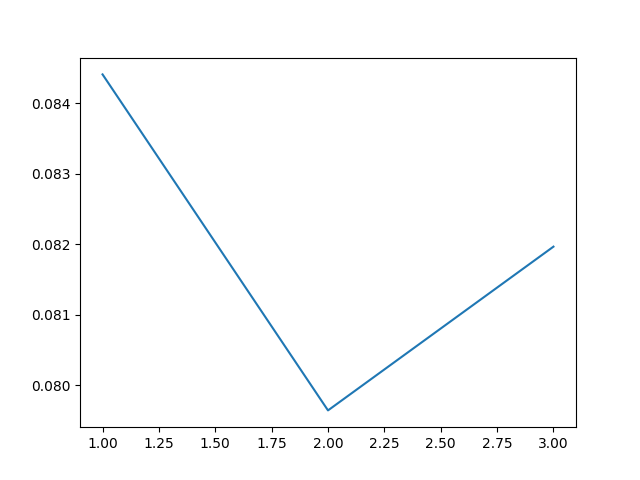

In [ ]:
from IPython.display import Image
image_path = '/content/experiments/base_model/figures/elect_ND_summary.png'
Image(image_path)

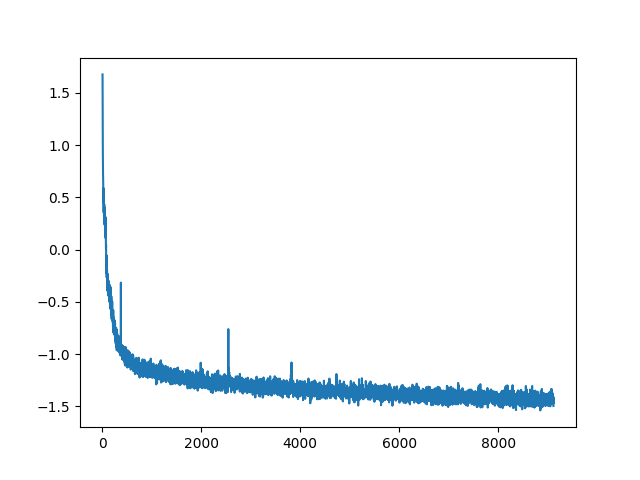

In [ ]:
from IPython.display import Image
image_path = '/content/experiments/base_model/figures/elect_loss_summary.png'
Image(image_path)

After 1st epoch

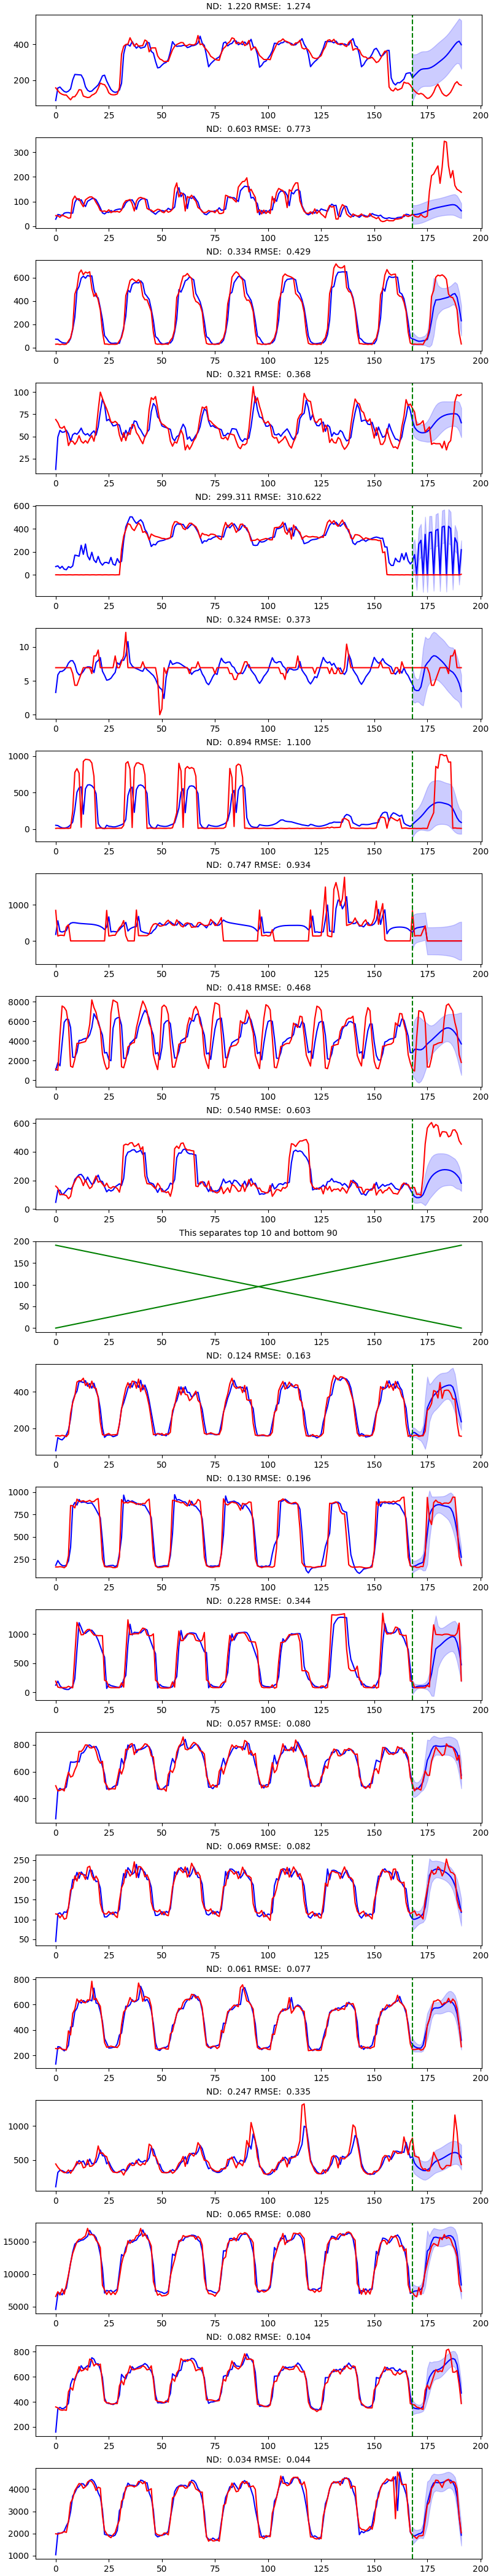

In [ ]:
from IPython.display import Image
image_path = '/content/experiments/base_model/figures/0.png'
Image(image_path)

after 2nd epoch

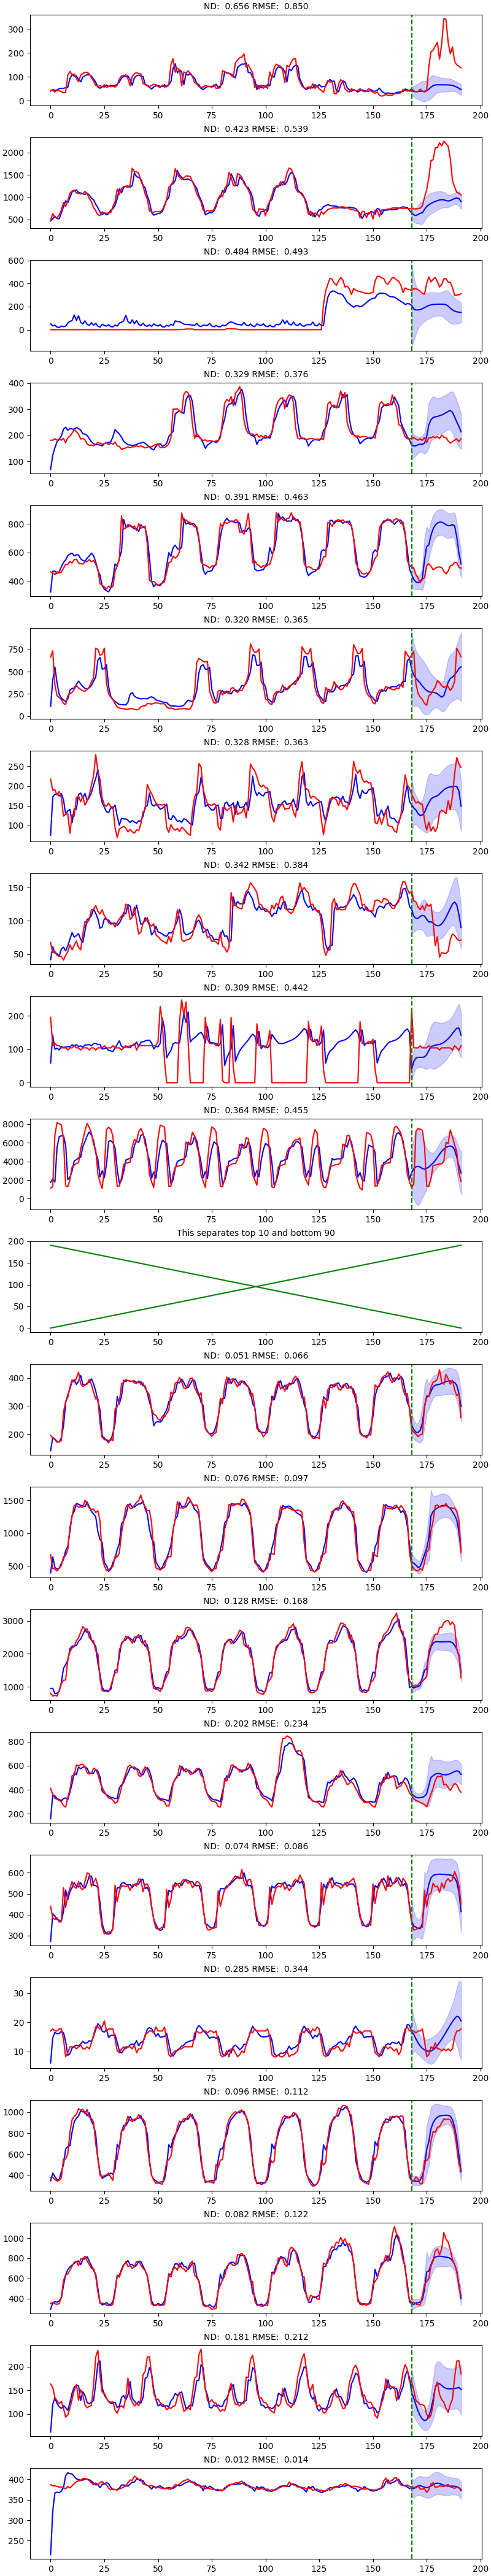

In [ ]:
from IPython.display import Image
image_path = '/content/experiments/base_model/figures/1.png'
Image(image_path)

After 3rd epoch

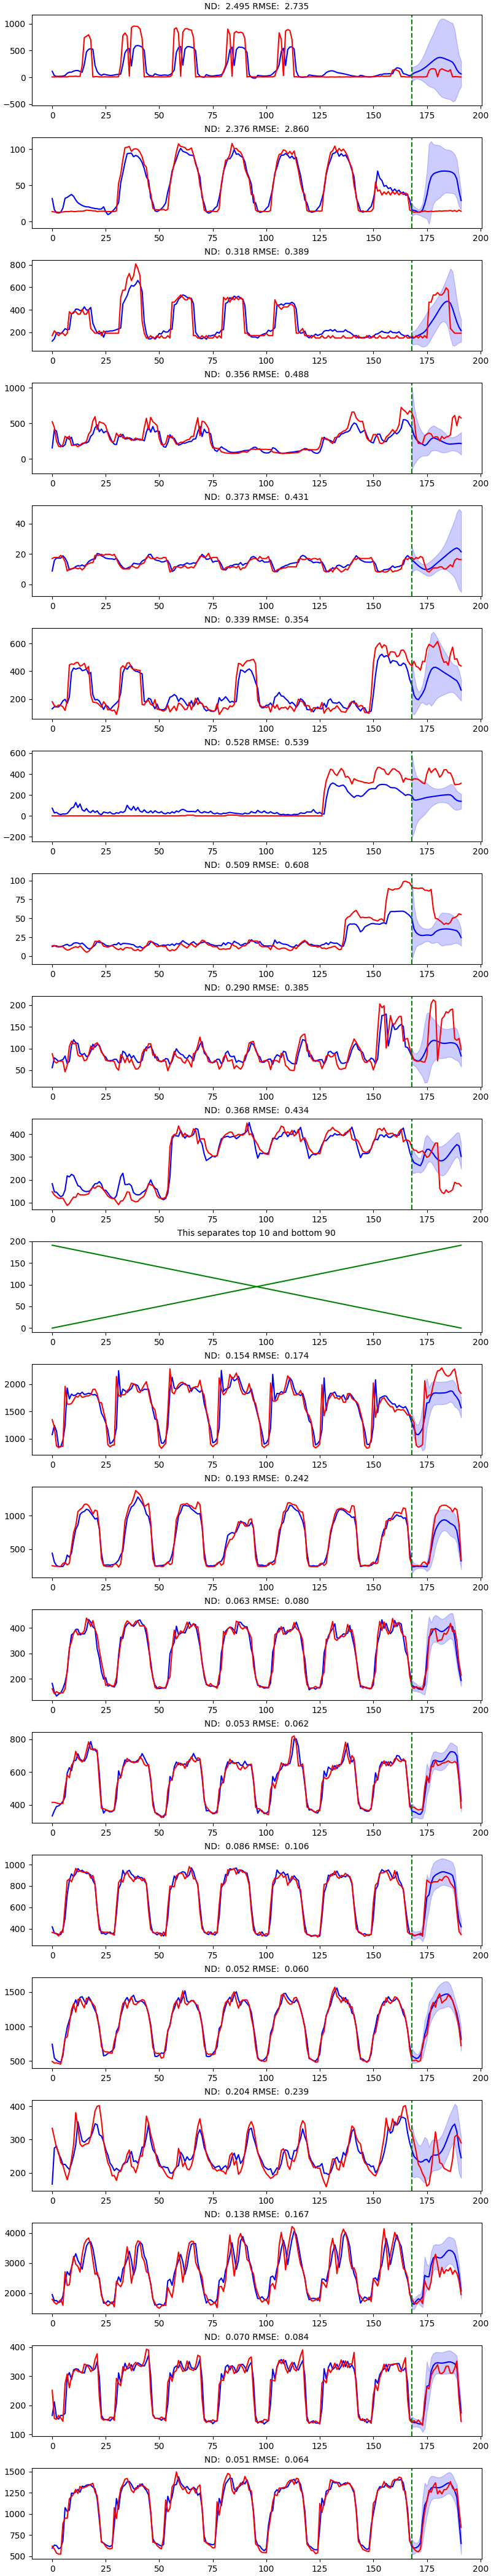

In [ ]:
from IPython.display import Image
image_path = '/content/experiments/base_model/figures/2.png'
Image(image_path)

For comparison, the ND summary graph and loss we got after training it for 20 epochs, 64 batch-size:-

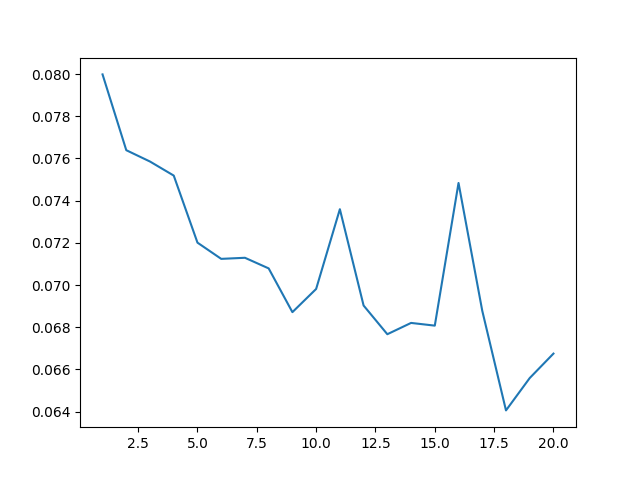

In [ ]:
from IPython.display import Image
image_path = '/content/elect_ND_summary.png'
Image(image_path)

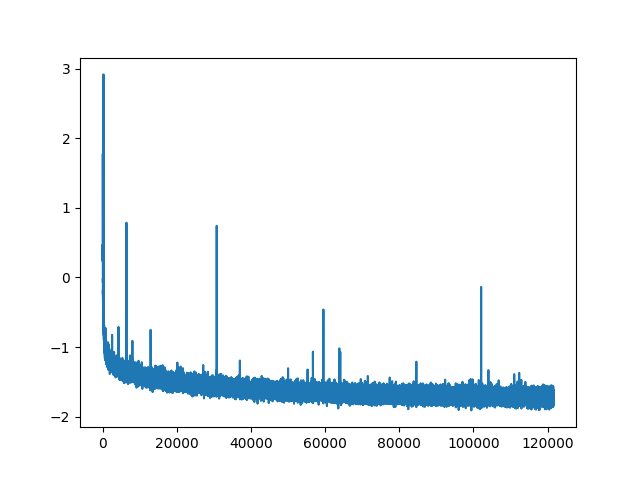

In [ ]:
from IPython.display import Image
image_path = '/content/elect_loss_summary.png'
Image(image_path)

contents of train.log file

In [ ]:
log_file_path = '/content/experiments/base_model/train.log'
with open(log_file_path, 'r') as file:
    log_content = file.read()

from IPython.display import Markdown
Markdown(f'```{log_content}```')

```[09:23:34] DeepAR.Train: Loading the datasets...
[09:23:38] DeepAR.Data: train_len: 389101
[09:23:38] DeepAR.Data: building datasets from data/elect...
[09:23:38] DeepAR.Data: test_len: 2590
[09:23:38] DeepAR.Data: building datasets from data/elect...
[09:23:38] DeepAR.Data: weights: tensor([4.5579e-08, 4.7663e-08, 4.8446e-08,  ..., 8.4827e-05, 8.4776e-05,
        8.4272e-05], dtype=torch.float64)
[09:23:38] DeepAR.Data: num samples: 389101
[09:23:38] DeepAR.Train: Loading complete.
[09:23:38] DeepAR.Train: Model: 
Net(
  (embedding): Embedding(370, 20)
  (lstm): LSTM(25, 40, num_layers=3, dropout=0.1)
  (relu): ReLU()
  (distribution_mu): Linear(in_features=120, out_features=1, bias=True)
  (distribution_presigma): Linear(in_features=120, out_features=1, bias=True)
  (distribution_sigma): Softplus(beta=1, threshold=20)
)
[09:23:43] DeepAR.Train: Starting training for 20 epoch(s)
[09:23:43] DeepAR.Train: begin training and evaluation
[09:23:43] DeepAR.Train: Epoch 1/20
[09:23:51] DeepAR.Eval: - Full test metrics: ND: 0.850; RMSE: 6.183; test_loss: 7.981
[09:23:51] DeepAR.Train: train_loss: 1.7615861892700195
[09:23:51] DeepAR.Train: train_loss: 1.7615861892700195
[09:34:57] DeepAR.Eval: - Full test metrics: ND: 0.096; RMSE: 0.595; test_loss: 5.877
[09:34:57] DeepAR.Train: train_loss: -1.1772658030192058
[09:45:23] DeepAR.Eval: - Full test metrics: ND: 0.093; RMSE: 0.588; test_loss: 5.704
[09:45:23] DeepAR.Train: train_loss: -1.2339127858479817
[09:55:48] DeepAR.Eval: - Full test metrics: ND: 0.100; RMSE: 0.581; test_loss: 5.659
[09:55:48] DeepAR.Train: train_loss: -1.162429412206014
[10:06:16] DeepAR.Eval: - Full test metrics: ND: 0.087; RMSE: 0.568; test_loss: 5.597
[10:06:16] DeepAR.Train: train_loss: -1.278276761372884
[10:16:44] DeepAR.Eval: - Full test metrics: ND: 0.082; RMSE: 0.531; test_loss: 5.575
[10:16:44] DeepAR.Train: train_loss: -1.3346842130025227
[10:27:13] DeepAR.Eval: - Full test metrics: ND: 0.083; RMSE: 0.547; test_loss: 5.573
[10:27:13] DeepAR.Train: train_loss: -1.3605270385742188
[10:28:14] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.518; test_loss: 5.540
[10:28:14] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_0.pth.tar
[10:28:14] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[10:28:14] DeepAR.Train: - Found new best ND
[10:28:14] DeepAR.Train: Current Best ND is: 0.07999
[10:28:14] DeepAR.Train: Epoch 2/20
[10:28:24] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.507; test_loss: 5.539
[10:28:24] DeepAR.Train: train_loss: -1.3956928253173828
[10:28:24] DeepAR.Train: train_loss: -1.3956928253173828
[10:38:55] DeepAR.Eval: - Full test metrics: ND: 0.086; RMSE: 0.604; test_loss: 5.526
[10:38:55] DeepAR.Train: train_loss: -1.385928789774577
[10:49:25] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.515; test_loss: 5.517
[10:49:25] DeepAR.Train: train_loss: -1.3865105311075847
[11:00:05] DeepAR.Eval: - Full test metrics: ND: 0.082; RMSE: 0.559; test_loss: 5.479
[11:00:05] DeepAR.Train: train_loss: -1.3963572184244792
[11:10:37] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.533; test_loss: 5.467
[11:10:37] DeepAR.Train: train_loss: -1.3118681907653809
[11:21:06] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.540; test_loss: 5.453
[11:21:06] DeepAR.Train: train_loss: -1.3832081158955891
[11:31:39] DeepAR.Eval: - Full test metrics: ND: 0.095; RMSE: 0.779; test_loss: 5.467
[11:31:39] DeepAR.Train: train_loss: -1.4492519696553547
[11:32:36] DeepAR.Eval: - Full test metrics: ND: 0.076; RMSE: 0.574; test_loss: 5.442
[11:32:36] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_1.pth.tar
[11:32:37] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[11:32:37] DeepAR.Train: - Found new best ND
[11:32:37] DeepAR.Train: Current Best ND is: 0.07639
[11:32:37] DeepAR.Train: Epoch 3/20
[11:32:46] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.627; test_loss: 5.443
[11:32:46] DeepAR.Train: train_loss: -1.5010604858398438
[11:32:46] DeepAR.Train: train_loss: -1.5010604858398438
[11:43:21] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.593; test_loss: 5.459
[11:43:21] DeepAR.Train: train_loss: -1.4876044591267903
[11:53:55] DeepAR.Eval: - Full test metrics: ND: 0.077; RMSE: 0.520; test_loss: 5.431
[11:53:55] DeepAR.Train: train_loss: -1.5562763214111328
[12:04:37] DeepAR.Eval: - Full test metrics: ND: 0.075; RMSE: 0.501; test_loss: 5.424
[12:04:38] DeepAR.Train: train_loss: -1.4679899215698242
[12:15:13] DeepAR.Eval: - Full test metrics: ND: 0.079; RMSE: 0.545; test_loss: 5.418
[12:15:13] DeepAR.Train: train_loss: -1.4624444643656414
[12:25:43] DeepAR.Eval: - Full test metrics: ND: 0.074; RMSE: 0.506; test_loss: 5.412
[12:25:43] DeepAR.Train: train_loss: -1.4485071500142415
[12:36:14] DeepAR.Eval: - Full test metrics: ND: 0.076; RMSE: 0.560; test_loss: 5.412
[12:36:14] DeepAR.Train: train_loss: -1.508269468943278
[12:37:10] DeepAR.Eval: - Full test metrics: ND: 0.076; RMSE: 0.520; test_loss: 5.405
[12:37:10] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_2.pth.tar
[12:37:10] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[12:37:10] DeepAR.Train: - Found new best ND
[12:37:10] DeepAR.Train: Current Best ND is: 0.07586
[12:37:11] DeepAR.Train: Epoch 4/20
[12:37:19] DeepAR.Eval: - Full test metrics: ND: 0.076; RMSE: 0.539; test_loss: 5.403
[12:37:19] DeepAR.Train: train_loss: -1.4574629465738933
[12:37:19] DeepAR.Train: train_loss: -1.4574629465738933
[12:47:55] DeepAR.Eval: - Full test metrics: ND: 0.075; RMSE: 0.559; test_loss: 5.391
[12:47:55] DeepAR.Train: train_loss: -1.512116273244222
[12:58:27] DeepAR.Eval: - Full test metrics: ND: 0.074; RMSE: 0.473; test_loss: 5.467
[12:58:27] DeepAR.Train: train_loss: -1.555242697397868
[13:09:05] DeepAR.Eval: - Full test metrics: ND: 0.074; RMSE: 0.549; test_loss: 5.392
[13:09:05] DeepAR.Train: train_loss: -1.5106321970621746
[13:19:50] DeepAR.Eval: - Full test metrics: ND: 0.072; RMSE: 0.497; test_loss: 5.382
[13:19:50] DeepAR.Train: train_loss: -1.5467605590820312
[13:30:42] DeepAR.Eval: - Full test metrics: ND: 0.072; RMSE: 0.493; test_loss: 5.374
[13:30:42] DeepAR.Train: train_loss: -1.5905556678771973
[13:41:33] DeepAR.Eval: - Full test metrics: ND: 0.071; RMSE: 0.496; test_loss: 5.361
[13:41:33] DeepAR.Train: train_loss: -1.4049320220947266
[13:42:33] DeepAR.Eval: - Full test metrics: ND: 0.075; RMSE: 0.557; test_loss: 5.363
[13:42:33] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_3.pth.tar
[13:42:33] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[13:42:33] DeepAR.Train: - Found new best ND
[13:42:33] DeepAR.Train: Current Best ND is: 0.07519
[13:42:33] DeepAR.Train: Epoch 5/20
[13:42:44] DeepAR.Eval: - Full test metrics: ND: 0.080; RMSE: 0.626; test_loss: 5.370
[13:42:44] DeepAR.Train: train_loss: -1.4099254608154297
[13:42:44] DeepAR.Train: train_loss: -1.4099254608154297
[13:53:27] DeepAR.Eval: - Full test metrics: ND: 0.072; RMSE: 0.511; test_loss: 5.356
[13:53:27] DeepAR.Train: train_loss: -1.5074111620585124
[14:04:09] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.515; test_loss: 5.351
[14:04:09] DeepAR.Train: train_loss: -1.5589776039123535
[14:14:49] DeepAR.Eval: - Full test metrics: ND: 0.089; RMSE: 0.702; test_loss: 5.374
[14:14:49] DeepAR.Train: train_loss: -1.399900754292806
[14:25:43] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.499; test_loss: 5.337
[14:25:43] DeepAR.Train: train_loss: -1.5495147705078125
[14:36:41] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.497; test_loss: 5.334
[14:36:41] DeepAR.Train: train_loss: -1.5269110997517903
[14:47:42] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.490; test_loss: 5.330
[14:47:42] DeepAR.Train: train_loss: -1.5422441164652507
[14:48:40] DeepAR.Eval: - Full test metrics: ND: 0.072; RMSE: 0.530; test_loss: 5.331
[14:48:40] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_4.pth.tar
[14:48:40] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[14:48:40] DeepAR.Train: - Found new best ND
[14:48:40] DeepAR.Train: Current Best ND is: 0.07201
[14:48:41] DeepAR.Train: Epoch 6/20
[14:48:50] DeepAR.Eval: - Full test metrics: ND: 0.071; RMSE: 0.533; test_loss: 5.331
[14:48:50] DeepAR.Train: train_loss: -1.6544227600097656
[14:48:50] DeepAR.Train: train_loss: -1.6544227600097656
[14:59:50] DeepAR.Eval: - Full test metrics: ND: 0.073; RMSE: 0.552; test_loss: 5.331
[14:59:50] DeepAR.Train: train_loss: -1.6082032521565754
[15:10:40] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.488; test_loss: 5.325
[15:10:40] DeepAR.Train: train_loss: -1.5645941098531086
[15:21:24] DeepAR.Eval: - Full test metrics: ND: 0.073; RMSE: 0.560; test_loss: 5.323
[15:21:24] DeepAR.Train: train_loss: -1.5834873517354329
[15:32:11] DeepAR.Eval: - Full test metrics: ND: 0.073; RMSE: 0.586; test_loss: 5.314
[15:32:11] DeepAR.Train: train_loss: -1.5873759587605794
[15:43:10] DeepAR.Eval: - Full test metrics: ND: 0.072; RMSE: 0.507; test_loss: 5.324
[15:43:10] DeepAR.Train: train_loss: -1.6210570335388184
[15:53:56] DeepAR.Eval: - Full test metrics: ND: 0.075; RMSE: 0.629; test_loss: 5.313
[15:53:57] DeepAR.Train: train_loss: -1.5985676447550456
[15:54:56] DeepAR.Eval: - Full test metrics: ND: 0.071; RMSE: 0.569; test_loss: 5.319
[15:54:56] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_5.pth.tar
[15:54:56] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[15:54:56] DeepAR.Train: - Found new best ND
[15:54:56] DeepAR.Train: Current Best ND is: 0.07124
[15:54:56] DeepAR.Train: Epoch 7/20
[15:55:05] DeepAR.Eval: - Full test metrics: ND: 0.071; RMSE: 0.560; test_loss: 5.320
[15:55:05] DeepAR.Train: train_loss: -1.510209560394287
[15:55:05] DeepAR.Train: train_loss: -1.510209560394287
[16:05:55] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.528; test_loss: 5.311
[16:05:55] DeepAR.Train: train_loss: -1.5874212582906086
[16:17:19] DeepAR.Eval: - Full test metrics: ND: 0.075; RMSE: 0.621; test_loss: 5.303
[16:17:19] DeepAR.Train: train_loss: -1.5388065973917644
[16:29:17] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.548; test_loss: 5.306
[16:29:17] DeepAR.Train: train_loss: -1.526814619700114
[16:40:03] DeepAR.Eval: - Full test metrics: ND: 0.071; RMSE: 0.561; test_loss: 5.301
[16:40:03] DeepAR.Train: train_loss: -1.568366527557373
[16:50:42] DeepAR.Eval: - Full test metrics: ND: 0.073; RMSE: 0.595; test_loss: 5.301
[16:50:42] DeepAR.Train: train_loss: -1.5524377822875977
[17:01:16] DeepAR.Eval: - Full test metrics: ND: 0.074; RMSE: 0.577; test_loss: 5.307
[17:01:16] DeepAR.Train: train_loss: -1.5970520973205566
[17:02:14] DeepAR.Eval: - Full test metrics: ND: 0.071; RMSE: 0.561; test_loss: 5.301
[17:02:14] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_6.pth.tar
[17:02:14] DeepAR.Train: Current Best ND is: 0.07124
[17:02:14] DeepAR.Train: Epoch 8/20
[17:02:23] DeepAR.Eval: - Full test metrics: ND: 0.074; RMSE: 0.600; test_loss: 5.306
[17:02:23] DeepAR.Train: train_loss: -1.59882656733195
[17:02:23] DeepAR.Train: train_loss: -1.59882656733195
[17:12:58] DeepAR.Eval: - Full test metrics: ND: 0.071; RMSE: 0.560; test_loss: 5.295
[17:12:58] DeepAR.Train: train_loss: -1.6772583325703938
[17:23:44] DeepAR.Eval: - Full test metrics: ND: 0.071; RMSE: 0.542; test_loss: 5.299
[17:23:44] DeepAR.Train: train_loss: -1.5714629491170247
[17:34:43] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.561; test_loss: 5.300
[17:34:43] DeepAR.Train: train_loss: -1.5871467590332031
[17:45:58] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.558; test_loss: 5.299
[17:45:58] DeepAR.Train: train_loss: -1.6331318219502766
[17:57:37] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.537; test_loss: 5.290
[17:57:37] DeepAR.Train: train_loss: -1.616918722788493
[18:09:29] DeepAR.Eval: - Full test metrics: ND: 0.072; RMSE: 0.610; test_loss: 5.287
[18:09:29] DeepAR.Train: train_loss: -1.6360904375712078
[18:10:37] DeepAR.Eval: - Full test metrics: ND: 0.071; RMSE: 0.563; test_loss: 5.288
[18:10:37] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_7.pth.tar
[18:10:37] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[18:10:37] DeepAR.Train: - Found new best ND
[18:10:37] DeepAR.Train: Current Best ND is: 0.07079
[18:10:37] DeepAR.Train: Epoch 9/20
[18:10:48] DeepAR.Eval: - Full test metrics: ND: 0.071; RMSE: 0.538; test_loss: 5.286
[18:10:48] DeepAR.Train: train_loss: -1.6307400067647297
[18:10:48] DeepAR.Train: train_loss: -1.6307400067647297
[18:23:50] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.518; test_loss: 5.287
[18:23:50] DeepAR.Train: train_loss: -1.6216618220011394
[18:36:22] DeepAR.Eval: - Full test metrics: ND: 0.074; RMSE: 0.634; test_loss: 5.285
[18:36:22] DeepAR.Train: train_loss: -1.6466190020243328
[18:48:59] DeepAR.Eval: - Full test metrics: ND: 0.074; RMSE: 0.614; test_loss: 5.286
[18:48:59] DeepAR.Train: train_loss: -1.6430188814798992
[19:01:37] DeepAR.Eval: - Full test metrics: ND: 0.072; RMSE: 0.598; test_loss: 5.282
[19:01:37] DeepAR.Train: train_loss: -1.6636996269226074
[19:15:17] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.584; test_loss: 5.276
[19:15:17] DeepAR.Train: train_loss: -1.609130859375
[19:31:25] DeepAR.Eval: - Full test metrics: ND: 0.072; RMSE: 0.581; test_loss: 5.288
[19:31:25] DeepAR.Train: train_loss: -1.6191426912943523
[19:32:53] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.576; test_loss: 5.275
[19:32:53] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_8.pth.tar
[19:32:53] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[19:32:53] DeepAR.Train: - Found new best ND
[19:32:53] DeepAR.Train: Current Best ND is: 0.06871
[19:32:53] DeepAR.Train: Epoch 10/20
[19:33:05] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.579; test_loss: 5.275
[19:33:05] DeepAR.Train: train_loss: -1.6403201421101887
[19:33:05] DeepAR.Train: train_loss: -1.6403201421101887
[19:48:45] DeepAR.Eval: - Full test metrics: ND: 0.075; RMSE: 0.663; test_loss: 5.276
[19:48:45] DeepAR.Train: train_loss: -1.570716381072998
[20:03:58] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.591; test_loss: 5.269
[20:03:58] DeepAR.Train: train_loss: -1.6276691754659016
[20:18:51] DeepAR.Eval: - Full test metrics: ND: 0.072; RMSE: 0.596; test_loss: 5.273
[20:18:51] DeepAR.Train: train_loss: -1.6528361638387044
[20:34:57] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.554; test_loss: 5.268
[20:34:57] DeepAR.Train: train_loss: -1.6201415061950684
[20:50:20] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.555; test_loss: 5.283
[20:50:20] DeepAR.Train: train_loss: -1.6654753684997559
[21:03:33] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.547; test_loss: 5.275
[21:03:33] DeepAR.Train: train_loss: -1.6053571701049805
[21:04:42] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.580; test_loss: 5.272
[21:04:42] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_9.pth.tar
[21:04:42] DeepAR.Train: Current Best ND is: 0.06871
[21:04:43] DeepAR.Train: Epoch 11/20
[21:04:53] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.585; test_loss: 5.270
[21:04:53] DeepAR.Train: train_loss: -1.6860017776489258
[21:04:53] DeepAR.Train: train_loss: -1.6860017776489258
[21:17:32] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.594; test_loss: 5.272
[21:17:32] DeepAR.Train: train_loss: -1.6975841522216797
[21:30:57] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.539; test_loss: 5.272
[21:30:57] DeepAR.Train: train_loss: -1.609256426493327
[21:43:59] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.534; test_loss: 5.265
[21:43:59] DeepAR.Train: train_loss: -1.6978826522827148
[21:57:05] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.542; test_loss: 5.265
[21:57:05] DeepAR.Train: train_loss: -1.6105265617370605
[22:12:42] DeepAR.Eval: - Full test metrics: ND: 0.078; RMSE: 0.697; test_loss: 5.268
[22:12:42] DeepAR.Train: train_loss: -1.662122090657552
[22:27:34] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.549; test_loss: 5.263
[22:27:34] DeepAR.Train: train_loss: -1.704682985941569
[22:29:15] DeepAR.Eval: - Full test metrics: ND: 0.074; RMSE: 0.619; test_loss: 5.267
[22:29:15] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_10.pth.tar
[22:29:15] DeepAR.Train: Current Best ND is: 0.06871
[22:29:15] DeepAR.Train: Epoch 12/20
[22:29:29] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.520; test_loss: 5.265
[22:29:29] DeepAR.Train: train_loss: -1.643374760945638
[22:29:29] DeepAR.Train: train_loss: -1.643374760945638
[22:47:47] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.550; test_loss: 5.264
[22:47:47] DeepAR.Train: train_loss: -1.6586793263753254
[23:07:50] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.532; test_loss: 5.258
[23:07:50] DeepAR.Train: train_loss: -1.6593478520711262
[23:31:39] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.547; test_loss: 5.265
[23:31:39] DeepAR.Train: train_loss: -1.6563631693522136
[23:45:09] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.526; test_loss: 5.257
[23:45:09] DeepAR.Train: train_loss: -1.821076234181722
[23:57:54] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.523; test_loss: 5.257
[23:57:54] DeepAR.Train: train_loss: -1.7887310981750488
[00:10:43] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.529; test_loss: 5.260
[00:10:43] DeepAR.Train: train_loss: -1.682021141052246
[00:11:55] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.528; test_loss: 5.260
[00:11:55] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_11.pth.tar
[00:11:55] DeepAR.Train: Current Best ND is: 0.06871
[00:11:55] DeepAR.Train: Epoch 13/20
[00:12:06] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.543; test_loss: 5.260
[00:12:06] DeepAR.Train: train_loss: -1.6413995424906414
[00:12:06] DeepAR.Train: train_loss: -1.6413995424906414
[00:24:54] DeepAR.Eval: - Full test metrics: ND: 0.071; RMSE: 0.568; test_loss: 5.258
[00:24:54] DeepAR.Train: train_loss: -1.7694104512532551
[00:38:02] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.503; test_loss: 5.261
[00:38:02] DeepAR.Train: train_loss: -1.6983447074890137
[00:51:12] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.521; test_loss: 5.253
[00:51:12] DeepAR.Train: train_loss: -1.6759945551554363
[01:04:09] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.521; test_loss: 5.253
[01:04:09] DeepAR.Train: train_loss: -1.6860318183898926
[01:20:22] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.536; test_loss: 5.253
[01:20:22] DeepAR.Train: train_loss: -1.6474788983662922
[01:38:06] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.530; test_loss: 5.251
[01:38:06] DeepAR.Train: train_loss: -1.861780325571696
[01:39:32] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.517; test_loss: 5.252
[01:39:32] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_12.pth.tar
[01:39:32] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[01:39:32] DeepAR.Train: - Found new best ND
[01:39:32] DeepAR.Train: Current Best ND is: 0.06767
[01:39:33] DeepAR.Train: Epoch 14/20
[01:39:45] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.520; test_loss: 5.254
[01:39:45] DeepAR.Train: train_loss: -1.7003726959228516
[01:39:45] DeepAR.Train: train_loss: -1.7003726959228516
[01:54:51] DeepAR.Eval: - Full test metrics: ND: 0.066; RMSE: 0.480; test_loss: 5.255
[01:54:51] DeepAR.Train: train_loss: -1.618736743927002
[02:09:43] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.552; test_loss: 5.253
[02:09:43] DeepAR.Train: train_loss: -1.697449525197347
[02:24:24] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.526; test_loss: 5.247
[02:24:24] DeepAR.Train: train_loss: -1.6807607014973958
[02:38:31] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.493; test_loss: 5.249
[02:38:31] DeepAR.Train: train_loss: -1.7195714314778645
[02:50:50] DeepAR.Eval: - Full test metrics: ND: 0.071; RMSE: 0.558; test_loss: 5.250
[02:50:50] DeepAR.Train: train_loss: -1.7269336382548015
[03:03:09] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.514; test_loss: 5.247
[03:03:09] DeepAR.Train: train_loss: -1.6363396644592285
[03:04:19] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.539; test_loss: 5.252
[03:04:19] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_13.pth.tar
[03:04:19] DeepAR.Train: Current Best ND is: 0.06767
[03:04:19] DeepAR.Train: Epoch 15/20
[03:04:30] DeepAR.Eval: - Full test metrics: ND: 0.066; RMSE: 0.506; test_loss: 5.247
[03:04:30] DeepAR.Train: train_loss: -1.680667559305827
[03:04:30] DeepAR.Train: train_loss: -1.680667559305827
[03:17:01] DeepAR.Eval: - Full test metrics: ND: 0.066; RMSE: 0.476; test_loss: 5.244
[03:17:01] DeepAR.Train: train_loss: -1.571689287821452
[03:29:26] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.510; test_loss: 5.244
[03:29:26] DeepAR.Train: train_loss: -1.6702133814493816
[03:41:48] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.486; test_loss: 5.243
[03:41:48] DeepAR.Train: train_loss: -1.7752799987792969
[03:54:12] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.545; test_loss: 5.247
[03:54:12] DeepAR.Train: train_loss: -1.7637906074523926
[04:06:48] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.490; test_loss: 5.246
[04:06:48] DeepAR.Train: train_loss: -1.652910868326823
[04:19:18] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.571; test_loss: 5.247
[04:19:18] DeepAR.Train: train_loss: -1.6609257062276204
[04:20:26] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.531; test_loss: 5.246
[04:20:26] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_14.pth.tar
[04:20:26] DeepAR.Train: Current Best ND is: 0.06767
[04:20:26] DeepAR.Train: Epoch 16/20
[04:20:36] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.542; test_loss: 5.243
[04:20:36] DeepAR.Train: train_loss: -1.579348087310791
[04:20:36] DeepAR.Train: train_loss: -1.579348087310791
[04:34:14] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.519; test_loss: 5.243
[04:34:14] DeepAR.Train: train_loss: -1.629640261332194
[04:49:24] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.499; test_loss: 5.244
[04:49:24] DeepAR.Train: train_loss: -1.7093524932861328
[05:03:10] DeepAR.Eval: - Full test metrics: ND: 0.066; RMSE: 0.479; test_loss: 5.251
[05:03:10] DeepAR.Train: train_loss: -1.7013136545817058
[05:17:15] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.522; test_loss: 5.237
[05:17:15] DeepAR.Train: train_loss: -1.8090044657389324
[05:32:05] DeepAR.Eval: - Full test metrics: ND: 0.065; RMSE: 0.477; test_loss: 5.244
[05:32:05] DeepAR.Train: train_loss: -1.7121073404947917
[05:46:06] DeepAR.Eval: - Full test metrics: ND: 0.066; RMSE: 0.491; test_loss: 5.234
[05:46:06] DeepAR.Train: train_loss: -1.711179256439209
[05:47:20] DeepAR.Eval: - Full test metrics: ND: 0.075; RMSE: 0.608; test_loss: 5.252
[05:47:20] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_15.pth.tar
[05:47:20] DeepAR.Train: Current Best ND is: 0.06767
[05:47:21] DeepAR.Train: Epoch 17/20
[05:47:35] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.538; test_loss: 5.238
[05:47:35] DeepAR.Train: train_loss: -1.7502102851867676
[05:47:35] DeepAR.Train: train_loss: -1.7502102851867676
[06:02:13] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.508; test_loss: 5.236
[06:02:13] DeepAR.Train: train_loss: -1.7106075286865234
[06:17:35] DeepAR.Eval: - Full test metrics: ND: 0.072; RMSE: 0.563; test_loss: 5.267
[06:17:35] DeepAR.Train: train_loss: -1.5960817337036133
[06:30:40] DeepAR.Eval: - Full test metrics: ND: 0.066; RMSE: 0.513; test_loss: 5.234
[06:30:40] DeepAR.Train: train_loss: -1.6165556907653809
[06:43:25] DeepAR.Eval: - Full test metrics: ND: 0.066; RMSE: 0.511; test_loss: 5.238
[06:43:25] DeepAR.Train: train_loss: -1.6856128374735515
[06:55:54] DeepAR.Eval: - Full test metrics: ND: 0.065; RMSE: 0.508; test_loss: 5.243
[06:55:54] DeepAR.Train: train_loss: -1.6857436498006184
[07:08:26] DeepAR.Eval: - Full test metrics: ND: 0.066; RMSE: 0.518; test_loss: 5.230
[07:08:26] DeepAR.Train: train_loss: -1.798035462697347
[07:09:34] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.526; test_loss: 5.234
[07:09:34] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_16.pth.tar
[07:09:34] DeepAR.Train: Current Best ND is: 0.06767
[07:09:35] DeepAR.Train: Epoch 18/20
[07:09:45] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.505; test_loss: 5.235
[07:09:45] DeepAR.Train: train_loss: -1.7108543713887532
[07:09:45] DeepAR.Train: train_loss: -1.7108543713887532
[07:22:18] DeepAR.Eval: - Full test metrics: ND: 0.065; RMSE: 0.503; test_loss: 5.232
[07:22:18] DeepAR.Train: train_loss: -1.7565304438273113
[07:34:37] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.490; test_loss: 5.247
[07:34:37] DeepAR.Train: train_loss: -1.677087942759196
[07:49:37] DeepAR.Eval: - Full test metrics: ND: 0.065; RMSE: 0.496; test_loss: 5.226
[07:49:37] DeepAR.Train: train_loss: -1.7609081268310547
[08:17:12] DeepAR.Eval: - Full test metrics: ND: 0.065; RMSE: 0.488; test_loss: 5.234
[08:17:12] DeepAR.Train: train_loss: -1.747550328572591
[08:35:31] DeepAR.Eval: - Full test metrics: ND: 0.066; RMSE: 0.496; test_loss: 5.231
[08:35:31] DeepAR.Train: train_loss: -1.788517951965332
[08:48:25] DeepAR.Eval: - Full test metrics: ND: 0.065; RMSE: 0.488; test_loss: 5.231
[08:48:25] DeepAR.Train: train_loss: -1.821694056193034
[08:49:36] DeepAR.Eval: - Full test metrics: ND: 0.064; RMSE: 0.466; test_loss: 5.238
[08:49:36] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_17.pth.tar
[08:49:36] DeepAR.Utils: Best checkpoint copied to best.pth.tar
[08:49:36] DeepAR.Train: - Found new best ND
[08:49:36] DeepAR.Train: Current Best ND is: 0.06405
[08:49:36] DeepAR.Train: Epoch 19/20
[08:49:47] DeepAR.Eval: - Full test metrics: ND: 0.064; RMSE: 0.467; test_loss: 5.236
[08:49:47] DeepAR.Train: train_loss: -1.7375311851501465
[08:49:47] DeepAR.Train: train_loss: -1.7375311851501465
[09:02:32] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.484; test_loss: 5.232
[09:02:32] DeepAR.Train: train_loss: -1.6554317474365234
[09:15:25] DeepAR.Eval: - Full test metrics: ND: 0.065; RMSE: 0.498; test_loss: 5.234
[09:15:25] DeepAR.Train: train_loss: -1.7556721369425456
[09:28:25] DeepAR.Eval: - Full test metrics: ND: 0.066; RMSE: 0.501; test_loss: 5.228
[09:28:25] DeepAR.Train: train_loss: -1.7582996686299641
[09:41:14] DeepAR.Eval: - Full test metrics: ND: 0.066; RMSE: 0.518; test_loss: 5.230
[09:41:14] DeepAR.Train: train_loss: -1.785291353861491
[09:53:58] DeepAR.Eval: - Full test metrics: ND: 0.065; RMSE: 0.492; test_loss: 5.226
[09:53:58] DeepAR.Train: train_loss: -1.7469127972920735
[10:07:04] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.530; test_loss: 5.230
[10:07:04] DeepAR.Train: train_loss: -1.7243730227152507
[10:08:17] DeepAR.Eval: - Full test metrics: ND: 0.066; RMSE: 0.501; test_loss: 5.229
[10:08:17] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_18.pth.tar
[10:08:17] DeepAR.Train: Current Best ND is: 0.06405
[10:08:17] DeepAR.Train: Epoch 20/20
[10:08:28] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.564; test_loss: 5.231
[10:08:28] DeepAR.Train: train_loss: -1.6865517298380535
[10:08:28] DeepAR.Train: train_loss: -1.6865517298380535
[10:21:57] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.531; test_loss: 5.237
[10:21:57] DeepAR.Train: train_loss: -1.6574085553487141
[10:35:10] DeepAR.Eval: - Full test metrics: ND: 0.065; RMSE: 0.505; test_loss: 5.234
[10:35:10] DeepAR.Train: train_loss: -1.6519444783528645
[10:48:23] DeepAR.Eval: - Full test metrics: ND: 0.070; RMSE: 0.588; test_loss: 5.228
[10:48:23] DeepAR.Train: train_loss: -1.632057825724284
[11:01:23] DeepAR.Eval: - Full test metrics: ND: 0.065; RMSE: 0.472; test_loss: 5.231
[11:01:23] DeepAR.Train: train_loss: -1.696121056874593
[11:14:15] DeepAR.Eval: - Full test metrics: ND: 0.069; RMSE: 0.549; test_loss: 5.223
[11:14:15] DeepAR.Train: train_loss: -1.6839019457499187
[11:27:51] DeepAR.Eval: - Full test metrics: ND: 0.068; RMSE: 0.566; test_loss: 5.221
[11:27:51] DeepAR.Train: train_loss: -1.752651850382487
[11:29:07] DeepAR.Eval: - Full test metrics: ND: 0.067; RMSE: 0.523; test_loss: 5.224
[11:29:07] DeepAR.Utils: Checkpoint saved to experiments/base_model/epoch_19.pth.tar
[11:29:07] DeepAR.Train: Current Best ND is: 0.06405
```

json file content used i.e the training parameters

In [ ]:
import json
json_file_path = '/content/experiments/base_model/params.json'
with open(json_file_path, 'r') as file:
    json_data = json.load(file)

print(json.dumps(json_data, indent=4))

{
    "learning_rate": 0.001,
    "batch_size": 128,
    "lstm_layers": 3,
    "num_epochs": 3,
    "train_window": 192,
    "test_window": 192,
    "predict_start": 168,
    "test_predict_start": 168,
    "predict_steps": 24,
    "num_class": 370,
    "cov_dim": 4,
    "lstm_hidden_dim": 40,
    "embedding_dim": 20,
    "sample_times": 200,
    "lstm_dropout": 0.1,
    "predict_batch": 256
}


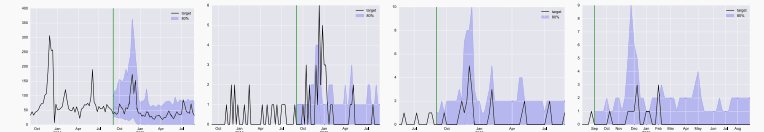

In [ ]:
from IPython.display import Image
image_path = '/content/ref_epoch_result_from_paper.png'
Image(image_path)